# Reto: Precio por m2


# Primera parte: 

- La base inicial se transformó utiluzando PowerQuery en Excel.
- Se dividió columnas de locación para obtener tres columnas: calle, colonia y estado.
- Se eliminaron 16 columnas que repetían información para quedar con 18 columnas.
- La columna "disposition" contaba únicamente con 20 observaciones, por lo que se eliminó.
- Aun se presenta errores en las columnas de texto, caracteres especiales en nombres.


In [69]:
#Dependencias
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [70]:
# Dependencias para modelo de regresión lineal
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import statsmodels.api as sm

In [ ]:
import shap

In [71]:
# Dependencias para modelo de random forest
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [73]:
# Dependencias para SQL
import sqlalchemy as sql
from sqlalchemy import create_engine
import psycopg2
from sqlalchemy import MetaData

In [ ]:
# AWS password
from config import key

# Cargando la base

In [33]:
reto_precios_to_load= 'C:/Users/alelo/Documents/DD360/Precios_por_m2/reto_precios_v1.csv'


# Análisis Exploratorio

In [34]:
#Convirtiendo la base en Dataframe
precios_df= pd.read_csv(reto_precios_to_load)

#Primeras filas del dataframe
precios_df.head()

,street,suburb,state,vendor,lat,lon,days_on_site,amenities,bathrooms,cellars,num_floors,monthly_fee_mxn,parking_lots,beds,department_type,m2,final_price,price_square_meter
0,Sinaloa 20,"Roma Sur, Roma Sur, Cuauhtémoc",Distrito Federal,Investemx,19.421317,-99.164182,5,3,2,0,1,0.0,2,2,apt,127.0,9000000.0,70866.14
1,Tonala,"Roma Norte, Cuauhtémoc",Distrito Federal,Avitana,19.421029,-99.163541,7,2,1,0,0,0.0,1,1,apt,54.0,4264000.0,78962.96
2,Tepeji 43,"Roma Sur, Ciudad De México, Cdmx, México, Rom...",Distrito Federal,Ebranuncios,19.407814,-99.161872,4,0,3,2,3,0.0,2,3,apt,163.0,8093500.0,49653.37
3,Linares,"Roma Sur, Cuauhtémoc",Distrito Federal,Houm,19.404992,-99.160243,150,2,2,0,0,853.0,1,2,Loft,93.0,4000000.0,43010.75
4,Frontera,"Roma Norte, Cuauhtémoc",Distrito Federal,Contactobienesraicesgold,19.419693,-99.156036,52,4,2,0,0,0.0,1,2,apt,103.0,6732700.0,65366.02


In [35]:
# Información sobre las columnas y observaciones
precios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              981 non-null    object 
 1   suburb              981 non-null    object 
 2   state               981 non-null    object 
 3   vendor              981 non-null    object 
 4   lat                 981 non-null    float64
 5   lon                 981 non-null    float64
 6   days_on_site        981 non-null    int64  
 7   amenities           981 non-null    int64  
 8   bathrooms           981 non-null    int64  
 9   cellars             981 non-null    int64  
 10  num_floors          981 non-null    int64  
 11  monthly_fee_mxn     981 non-null    float64
 12  parking_lots        981 non-null    int64  
 13  beds                981 non-null    int64  
 14  department_type     981 non-null    object 
 15  m2                  981 non-null    float64
 16  final_pr

In [36]:
# Información sobre estadísticas descriptivas
precios_df[['days_on_site', 'amenities', 'bathrooms', 'cellars', 'num_floors', 'monthly_fee_mxn', 'parking_lots', 'beds', 'm2', 'final_price', 'price_square_meter']].describe().round(2)

,days_on_site,amenities,bathrooms,cellars,num_floors,monthly_fee_mxn,parking_lots,beds,m2,final_price,price_square_meter
count,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00
mean,103.48,2.10,1.97,0.05,0.31,28.92,1.33,2.10,111.82,6144619.88,61049.00
std,116.79,2.23,0.89,0.23,1.30,287.13,0.48,0.63,231.60,2907088.80,19327.44
min,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,31.00,634217.00,582.25
25%,31.00,0.00,2.00,0.00,0.00,0.00,1.00,2.00,75.00,4330000.00,52294.12
50%,59.00,2.00,2.00,0.00,0.00,0.00,1.00,2.00,93.00,5511689.00,61271.47
75%,120.00,4.00,2.00,0.00,0.00,0.00,2.00,2.00,129.00,7700000.00,70175.44
max,730.00,8.00,23.00,2.00,12.00,4000.00,3.00,4.00,7210.00,22330000.00,150514.82


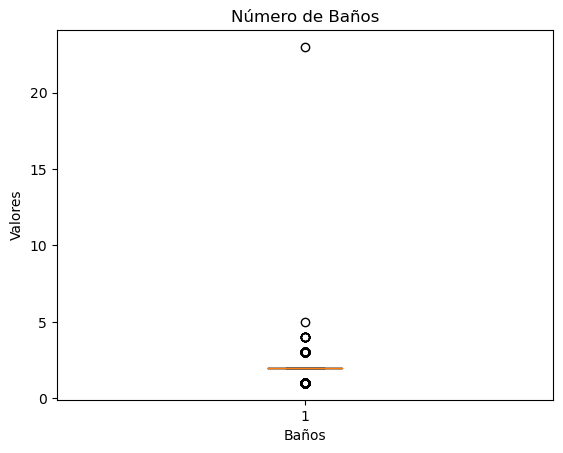

In [37]:
# box plot para número de baños, ya que el máximo es 23 y es un número ilógico para un departamento
plt.boxplot(precios_df['bathrooms'])

# Etiquetas de los ejes y título
plt.xlabel('Baños')
plt.ylabel('Valores')
plt.title('Número de Baños')

# Mostrar el box plot
plt.show()

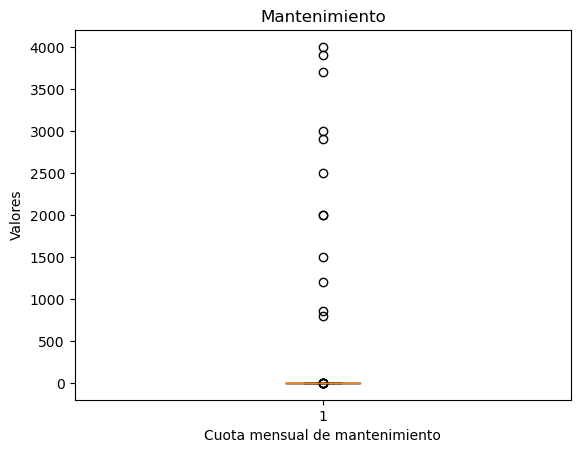

In [38]:
# Box plot para cuota mensual de mantenimiento para revisar si son outliers
plt.boxplot(precios_df['monthly_fee_mxn'])

# Etiquetas de los ejes y título
plt.xlabel('Cuota mensual de mantenimiento')
plt.ylabel('Valores')
plt.title('Mantenimiento')

# Mostrar el box plot
plt.show()

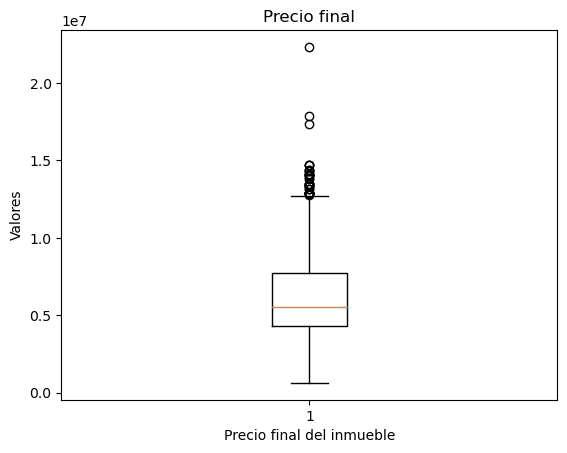

In [39]:
# Box plot para precio final
plt.boxplot(precios_df['final_price'])

# Etiquetas de los ejes y título
plt.xlabel('Precio final del inmueble')
plt.ylabel('Valores')
plt.title('Precio final')

# Mostrar el box plot
plt.show()

In [40]:
# Se tiene tres estados representados en la base de datos
len(precios_df.state.unique())

3

In [41]:
# Existen 141 compañias/empresas inmobiliarias
len(precios_df.vendor.unique())

141

In [42]:
#calles
len(precios_df.street.unique())


156

In [45]:
precios_df['street'].unique().tolist()

['Sinaloa 20 ',
 'Tonala',
 'Tepeji 43',
 'Linares',
 'Frontera',
 'Chilpancingo',
 'Roma Sur',
 'Colima',
 'Cuauhtemoc',
 'Aguascalientes',
 'Roma Norte',
 'Viaducto Miguel Alemán',
 'Querétaro',
 'Av Chapultepec',
 'Coahuila',
 'SN',
 'Alejandría 111',
 'Quintana Roo',
 'Narvarte',
 'Roma',
 'Constitucion',
 'Avenida Baja California 15',
 'Nayarit',
 'Cordoba',
 'Tonala 177 Depto 302 Ph',
 'Bajio',
 'Chiapas',
 'Sinaloa',
 'Zacatecas',
 'Tlacotalpan',
 'Tepeji',
 'Durango',
 'Salina Cruz',
 'Monterrey',
 '2 De Abril 2007',
 'Viaducto',
 'Baja California',
 'San Luis Potosi',
 'Queretaro',
 'Av. Álvaro Obregón',
 'San Luis Potosi 136',
 'Av. Chapultepec',
 'Tonalá',
 'Departamentos Nuevos Roma Norte Coahuila',
 'Tlacotalpan 89',
 'Huatabampo 30',
 'Avenida Chapultepec',
 'Córdoba 223',
 'Tonala 177 Depto 301 Ph',
 'Acayucan',
 'Venta De Departamento En Colonia Roma',
 'Guanajuato',
 'Puerto Mexico',
 'Departamentos En Preventa Av. Eugenio Garza Sada',
 'Viaducto Miguel Aleman',
 'Bají

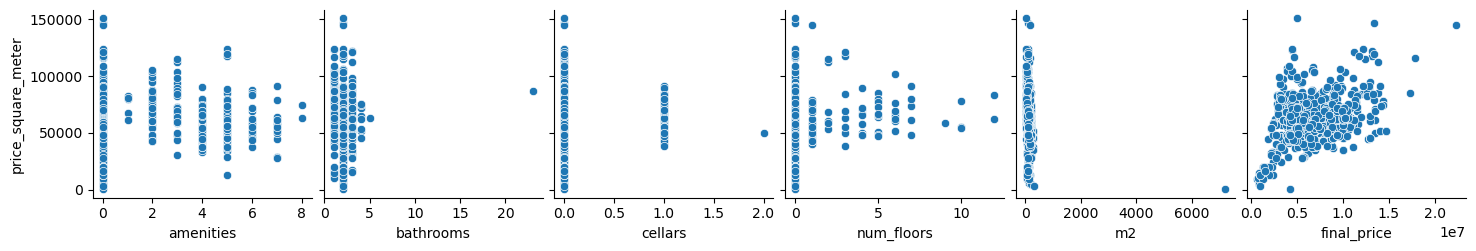

In [46]:
# Diagrama de dispersión para observar relaciones entre las variables
sns.pairplot(precios_df, x_vars=['amenities', 'bathrooms', 'cellars', 'num_floors', 'm2','final_price'], y_vars=['price_square_meter'])
plt.show()

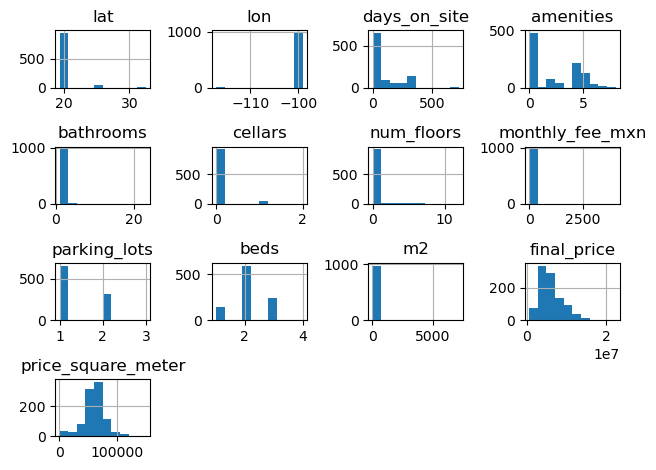

In [47]:
# Visualizando distribuciones, histogramas
precios_df.hist()
plt.tight_layout()
plt.show()

In [48]:
# DataFrame con las variables relevantes
variables = ['days_on_site', 'amenities', 'bathrooms','cellars', 'num_floors', 'monthly_fee_mxn', 'parking_lots', 'beds', 'm2', 'final_price']
precios_df2 = precios_df[['price_square_meter'] + variables]

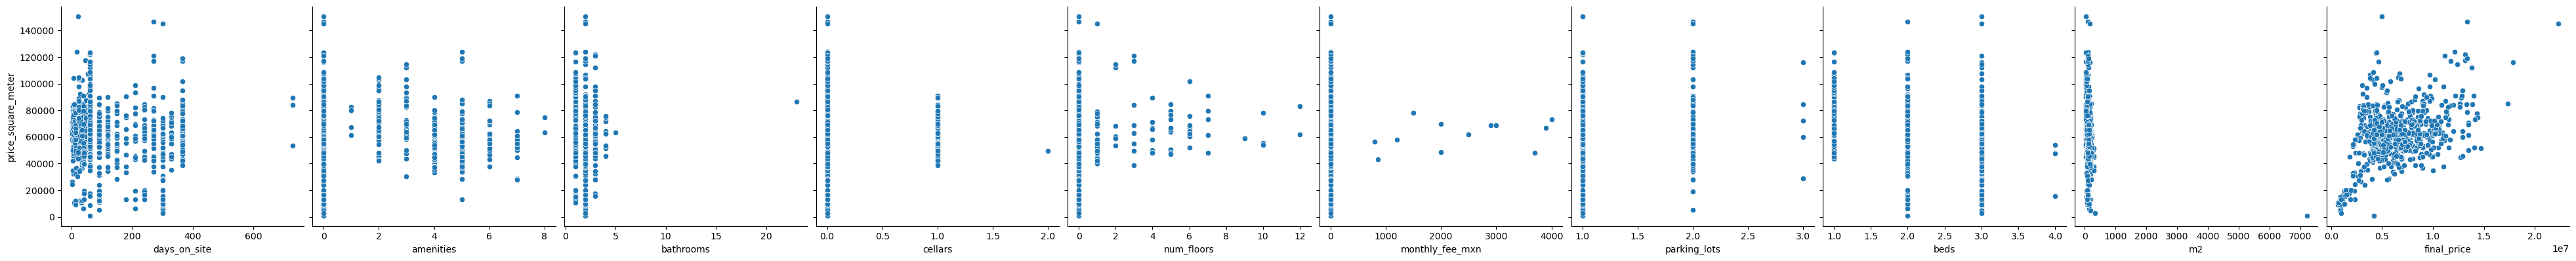

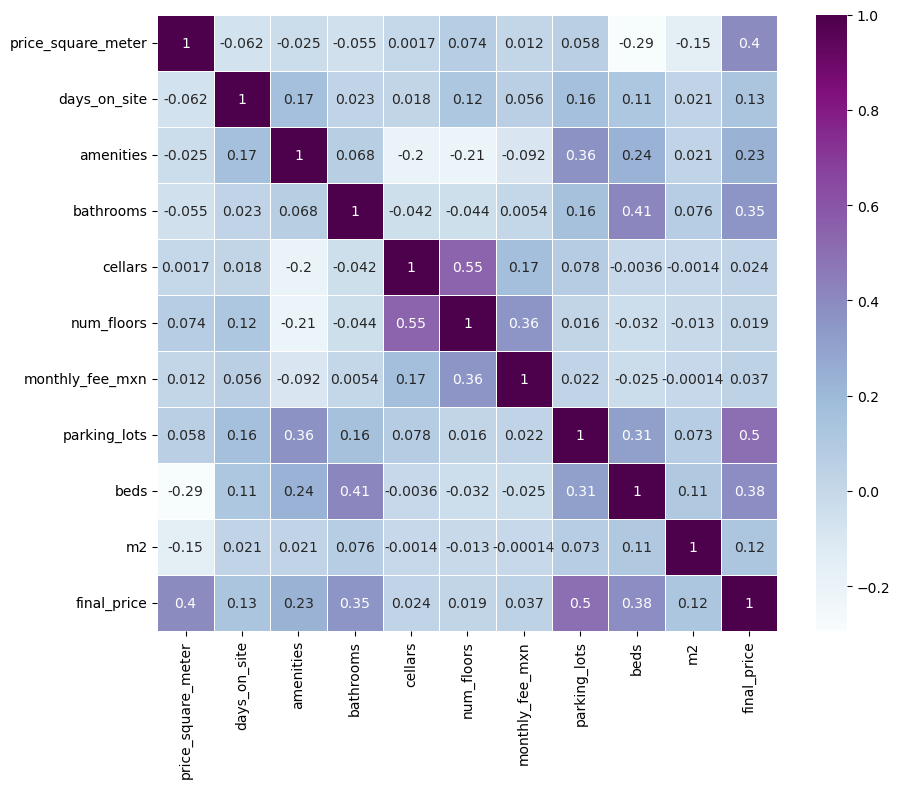

In [49]:
# Gráfico de dispersión entre "price_square_meter" y otras variables
sns.pairplot(precios_df2,x_vars=variables, y_vars='price_square_meter', kind='scatter', height=4)

# Calcular la matriz de correlación
correlation_matrix = precios_df2.corr()

# Visualizar la matriz de correlación en un mapa de calor
# https://seaborn.pydata.org/generated/seaborn.heatmap.html 
# https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, linewidth=.5, cmap='BuPu')

# Mostrar los gráficos
plt.show()

## Regresión Lineal con StatsModel

In [51]:
# Usando StatsModel porque busco un resumen estadístico detallado
variables_modelo=['price_square_meter', 'days_on_site', 'amenities', 'bathrooms', 'cellars', 'num_floors', 'monthly_fee_mxn', 'parking_lots', 'beds', 'm2', 'final_price']
precios_modelo1_df= precios_df[variables_modelo]

In [52]:
# Separo variables
y = precios_modelo1_df['price_square_meter']
X = precios_modelo1_df.drop('price_square_meter', axis=1)

In [53]:
# Columna de intercepto
X = sm.add_constant(X)

In [55]:
# Modelo ajustado
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     price_square_meter   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     77.34
Date:                Fri, 26 May 2023   Prob (F-statistic):          2.96e-116
Time:                        01:11:00   Log-Likelihood:                -10786.
No. Observations:                 981   AIC:                         2.159e+04
Df Residuals:                     970   BIC:                         2.165e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.458e+04   1885.201     

## Regresion Lineal con Sklearn 

In [56]:
# Ya se separo las variables independientes con la dependiente previamente
# Divido datos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 

In [57]:
# Determinar la forma de los conjuntos de entrenamiento y prueba.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(784, 11)
(197, 11)
(784,)
(197,)


In [58]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [59]:
y_pred = model.predict(X_test)

In [64]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 211222417.26479995
R^2 Score: 0.4712426807500292


In [95]:
y_true = precios_modelo1_df['price_square_meter'].values

In [117]:
#Random Forest
y= precios_df['price_square_meter']
X= precios_df.drop(columns=['price_square_meter','street','suburb','state', 'vendor','lat','lon','department_type'])

In [118]:
X.head()

,days_on_site,amenities,bathrooms,cellars,num_floors,monthly_fee_mxn,parking_lots,beds,m2,final_price
0,5,3,2,0,1,0.0,2,2,127.0,9000000.0
1,7,2,1,0,0,0.0,1,1,54.0,4264000.0
2,4,0,3,2,3,0.0,2,3,163.0,8093500.0
3,150,2,2,0,0,853.0,1,2,93.0,4000000.0
4,52,4,2,0,0,0.0,1,2,103.0,6732700.0


In [119]:
X.count()

days_on_site       981
amenities          981
bathrooms          981
cellars            981
num_floors         981
monthly_fee_mxn    981
parking_lots       981
beds               981
m2                 981
final_price        981
dtype: int64

In [120]:
X.dtypes

days_on_site         int64
amenities            int64
bathrooms            int64
cellars              int64
num_floors           int64
monthly_fee_mxn    float64
parking_lots         int64
beds                 int64
m2                 float64
final_price        float64
dtype: object

In [121]:
# We define the target set using the ravel() method, which performs the same procedure on our target set data as the values attribute
y=precios_df["price_square_meter"].ravel()
y[:10]

array([70866.14, 78962.96, 49653.37, 43010.75, 65366.02, 47761.19,
       70866.14, 49553.57, 68781.56, 53000.  ])

In [122]:
# Split the data for train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

In [123]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(735, 10)
(246, 10)
(735,)
(246,)


In [124]:
#Create scaler instance
X_scaler=skl.preprocessing.StandardScaler()

#Fit the scaler
X_scaler.fit(X_train)

#Scale the data
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

In [127]:
from sklearn.ensemble import RandomForestRegressor

# Crear un modelo de regresión de bosque aleatorio
rf_model = RandomForestRegressor(n_estimators=200, random_state=0)

# Ajustar el modelo
rf_model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = rf_model.predict(X_test_scaled)
y_pred

array([ 49944.9404 ,  73298.5735 ,  64602.30765,  71005.3555 ,
        53253.545  ,  53991.2959 ,  54778.5621 ,  53420.74775,
        65635.0739 ,  67448.68885,  50877.52795,  34611.2468 ,
        72533.7548 ,  45429.43555,  62519.61295,  60772.8551 ,
        58906.83275,  54063.88865,  77949.5576 ,  72604.99365,
        53363.0954 ,  59136.00125,  85291.04935,  70983.8361 ,
        57099.65915,  45669.9759 ,  50448.88085,  65423.95255,
        65255.3745 , 102797.14245,  46721.75385,  67543.7887 ,
        37754.0224 ,  69466.33695,  12244.47385,  84437.7961 ,
        65812.16585,  50105.5887 ,  43854.84295,  62347.2316 ,
        50173.885  ,  60495.4717 ,  59764.79405,  90256.25895,
        54062.01425,  62417.16025,  64146.61885,  63711.9385 ,
        98916.16005,  72341.97905,  61179.19475,  62347.2316 ,
        67974.9699 ,  59276.6148 ,  54979.7532 ,  68470.15745,
        57741.24545,  45017.91765,  72651.7335 ,  43546.2634 ,
        59895.24845,  61117.5551 ,  59256.82585,  53927

In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test_scaled)

# Calcular el MAE
mae = mean_absolute_error(y_test, y_pred)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)

# Calcular el RMSE
rmse = np.sqrt(mse)

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

MAE: 1278.2718959349577
MSE: 6254584.771967867
RMSE: 2500.9167862941517
R^2: 0.9820009805611426


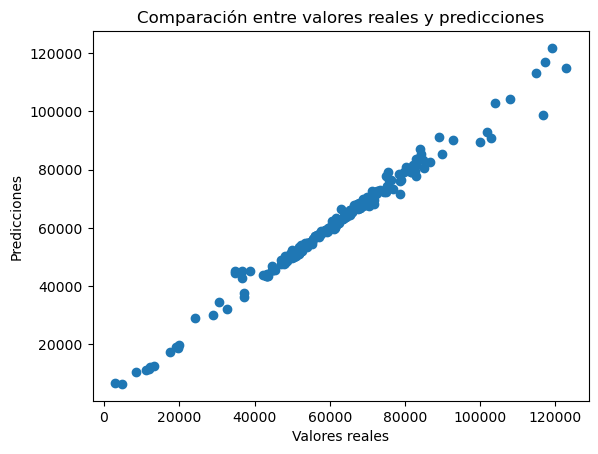

In [130]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test_scaled)

# Crear gráfico de dispersión
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()

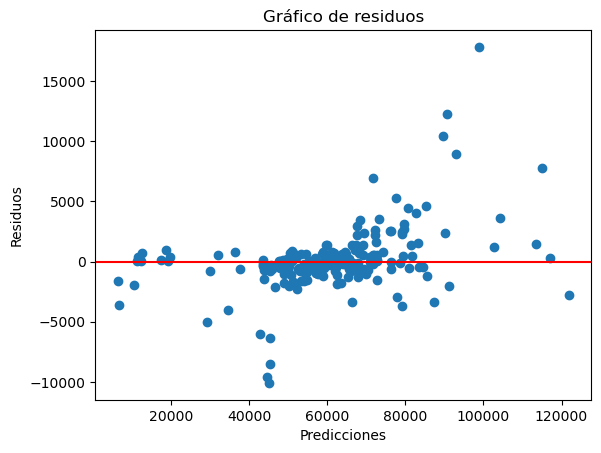

In [131]:
# Calcular los residuos
residuals = y_test - y_pred

# Crear gráfico de residuos
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.show()

In [132]:
y_true = precios_df['price_square_meter'].values

In [133]:
# Calcular el MAPE
def calculate_mape(y_true, y_pred):
    # Calcular el porcentaje de error absoluto
    errors = np.abs((y_true - y_pred) / y_true)
    
    # Calcular el MAPE promedio
    mape = np.mean(errors) * 100
    
    return mape

In [134]:
mape = calculate_mape(y_true, y_pred)
print("MAPE:", mape)

ValueError: operands could not be broadcast together with shapes (981,) (246,) 

In [135]:
from sklearn.metrics import mean_absolute_percentage_error

# Suponiendo que tienes tus arrays de y_true y y_pred
mape = mean_absolute_percentage_error(y_true, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [981, 246]